In [1]:
# Content from Proakis
# Code © 2019, Alexander Kain
import numpy as np
from numpy.fft import fft, ifft, rfft, irfft

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

import sympy as sym
sym.init_printing(use_unicode=True)

# 7.4. Frequency Analysis of Signals Using the DFT

Signals can be very long and their characteristics often change over time (e.g. speech), and thus in practice we make an assumption of stationarity and consider *segments* of the signal at a time. This has implications for frequency analysis using the DFT.

We already know that the highest frequency contained in a sampled signal is $F_s/2$. Moreover, we will limit the duration of the segment to the time interval

$$ T_0 = L T_s $$

where $L$ is the number of samples and $T_s$ is the sampling interval; this limits our ability to dinstinguish two frequency components that are separated by less than $1 / T_0 = 1 / (LT)$ in frequency.

The key insight is that limiting the duration (or truncating, or selecting a portion) of a long sequence $x[n]$ to $L$ samples is *equivalent* to multiplying $x[n]$ by a rectangular window $w[n]$ of length L:

$$ \hat{x}[n] = x[n] w[n] $$

where

$$w[n] = \begin{cases}
1, & 0 \leq n \leq L-1 \\
0   , & \textrm{otherwise} \\
\end{cases}
$$

Suppose that the $x[n]$ consists of a single sinusoid

$$ x[n] = \cos (\omega_0 n) $$

then the Fourier transform is, using the modulation theorem (in this case specifically) or the multiplication theorem (in general),

$$ x_1[n] \cdot x_2[n] \stackrel{\mathcal{F}}{\longleftrightarrow} 
\frac{1}{2\pi} \int_{2 \pi} X_1(\lambda) X_2(\omega - \lambda) d \lambda $$

$$ \hat{X}(\omega) = \frac{1}{2} \left( W(\omega - \omega_0) + W(\omega + \omega_0) \right) $$

where $W(\omega)$ is the Fourier transform of the rectangular window sequence, which we previously calculated to be

$$ W(\omega) = \frac{\sin(\omega L / 2)}{\sin(\omega/2)} e^{-j \omega (L-1) / 2} $$


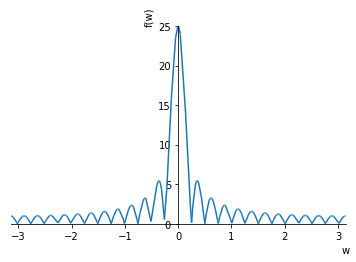

In [2]:
# Symbolically

w, L, w_0 = sym.symbols('w L w_0', real=True)
def W(w, L): 
    return (sym.sin(w * L / 2) / sym.sin(w / 2) * 
        sym.exp(-1j * w * (L - 1) / 2))

sym.plot(sym.Abs(W(w, 25)), (w, -sym.pi, sym.pi));

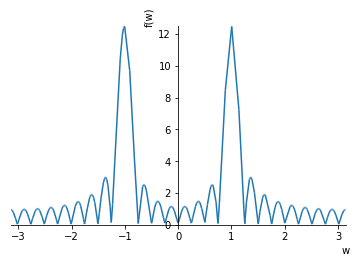

In [3]:
def X(w, w_0, L):
    return (W(w - w_0, L) + W(w + w_0, L)) / 2

sym.plot(sym.Abs(X(w, 1, 25)), (w, -sym.pi, sym.pi));

In [4]:
del w, L, w_0  # delete these objects

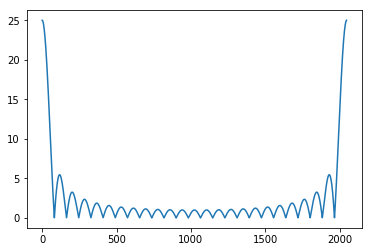

In [5]:
# Numerically
from scipy.signal.windows import boxcar

L = 25
w = boxcar(L)
W = fft(w, 2048)
plt.plot(abs(W));

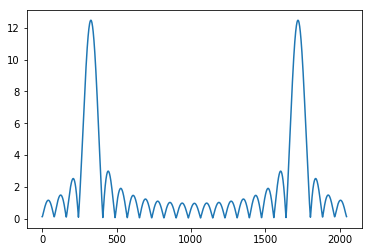

In [6]:
x = np.cos(np.arange(L)) * w
X = fft(x, 2048)
plt.plot(abs(X));

We note that the windowed spectrum is not localized to a single frequency, but instead it is spread out over the whole frequency range. Thus the power that was originally concentrated at a single frequency in $x[n]$ has been spread out ("leaked out") by the effect of the window into the entire frequency range, also known as *leakage* or smearing.

Windowing not only distorts the spectral estimate due to leakage, but it also reduces spectral resolution; to see this consider a signal with two frequency components

$$ x[n] = \cos (w_1 n) + \cos (w_2 n) $$

When this sequence is truncated to $L$ samples the windowed spectrum is

$$ \hat{X}(\omega) = \frac{1}{2} \left( W(\omega - \omega_1) + W(\omega + \omega_1) +
W(\omega - \omega_2) + W(\omega + \omega_2)
\right) $$

The spectrum $W(\omega)$ has its first zero-crossing at $\omega = 2 \pi / L$. Now if $|\omega_1 - \omega_2| < 2 \pi / L$, the terms $W(\omega - \omega_1)$ and $W(\omega - \omega_2)$ (and their counterparts) overlap, and consequently individual spectral lines will not be distinguishable; only if $|\omega_1 - \omega_2| \geq 2 \pi / L$ will we see two separate lobes in $\hat{X}(\omega)$. Thus, the ability to resolve spectral lines of different frequencies is limited by the window spectrum main lobe's width.

To illustrate, consider

$$ x[n] = \cos (0.2 \pi n) + \cos (0.22 \pi n) + \cos (0.6 \pi n) $$

for $L=25, 50, 100$:

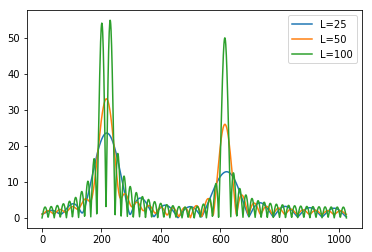

In [7]:
def demo(window=boxcar):
    """equation 7.4.8"""
    for L in [25, 50, 100]:
        x = (np.cos(np.arange(L) * 0.2 * np.pi) + 
             np.cos(np.arange(L) * 0.22 * np.pi) + 
             np.cos(np.arange(L) * 0.6 * np.pi))
        w = window(L)
        xhat = x * w
        Xhat = rfft(xhat, 2048)
        plt.plot(abs(Xhat), label=f'L={L}')
    plt.legend()
    
demo()

Note that it's not always practical to increase frequency resolution by increasing $L$, as this decreases resolution in time; an example of the uncertainty principle.

To reduce leakage, we can choose a window function that has lower sidelobes; however, this is obtained at the expense of an increase in the width of the main lobe. Consider the Hann (improper: Hanning) window:

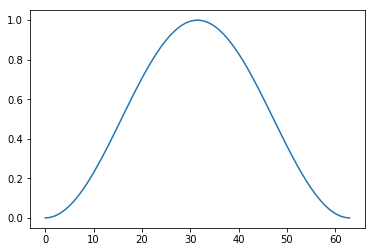

In [8]:
from scipy.signal.windows import hann

plt.plot(hann(64));

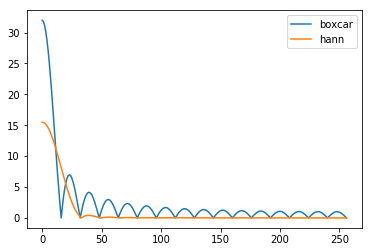

In [9]:
plt.plot(abs(rfft(boxcar(32), 512)), label='boxcar')
plt.plot(abs(rfft(hann(32), 512)), label='hann')
plt.legend();

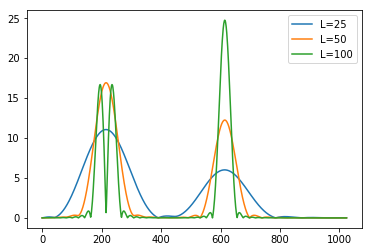

In [10]:
demo(hann)  # reduction in sidelobes and in resolution

In summary, if the spectrum of the window is relatively narrow in width compared to the spectrum of the signal, the window function only has a small (smoothing) effect on the resulting spectrum.

On the other hand, if the window function has a wide spectrum compared to the signal spectrum, as when $L$ is small, the window spectrum masks the signal spectrum, and thus the DFT of the windowed signal reflects the spectral characteristics of the window function:

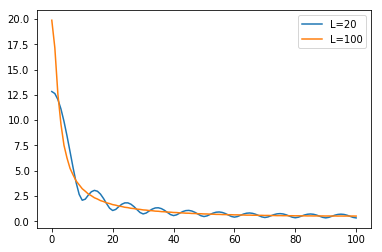

In [11]:
# Example 7.4.1
for L in [20, 100]:
    n = np.arange(L)
    x = (0.95) ** n
    plt.plot(abs(rfft(x, 200)), label=f'L={L}')
plt.legend();

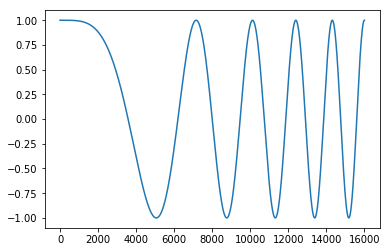

In [12]:
# Example: how to compute a spectrogram of a changing signal

Fs = 16000
N = 16000  # one second duration signal
n = np.arange(N)

def rise(f1, f2):
    f = np.linspace(f1, f1 + (f2 - f1) / 2, N)  # rising frequency
    w = 2 * np.pi * f / Fs
    return np.cos(w * n)

x = rise(0, 10)
plt.plot(x);

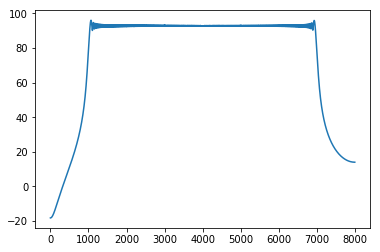

In [13]:
x = rise(1000, 7000)
plt.plot(20 * np.log(abs(rfft(x))));  # global power spectrum

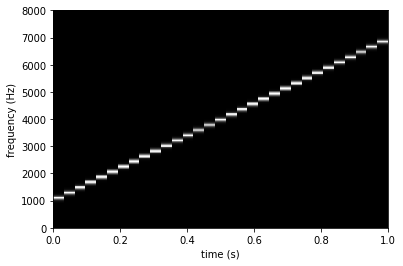

In [14]:
def specgram(x, NFFT=512, Fs=2, window=hann):
    B = len(x) // NFFT
    M = np.empty((B, NFFT // 2 + 1))
    w = window(NFFT)
    for b in range(B):
        a = b * NFFT
        f = x[a:(a + NFFT)]  # one frame
        M[b] = np.abs(rfft(f * w))
    plt.imshow(M.T,  # note the use of transpose
               cmap=plt.cm.gray, aspect='auto', origin='lower',
               extent=[0, len(x) / Fs, 0, Fs/2])
    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')

specgram(x, Fs=Fs)

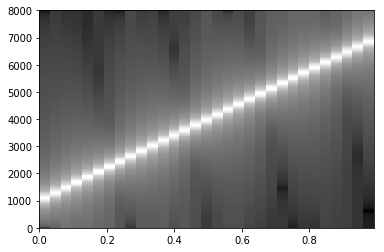

In [15]:
plt.specgram(x, NFFT=512, Fs=Fs, window=hann(512), 
            noverlap=0,  # 0 approximates above image, try other values
            cmap=plt.cm.gray);  # built into matplotlib